In [1]:
import sys
sys.path.append('../')

from util.mongodb_util import create_mongodb_connection, mongodb_to_df

df_from_db = mongodb_to_df(100000)
df = df_from_db.drop(columns=['_id'])
print(df_from_db.head())

                        _id  index                       hotel_name  \
0  5ffd648c6fb44d5f602ea1be      0  \nTower Suites by Blue Orchid\n   
1  5ffd648c6fb44d5f602ea1bf      1  \nTower Suites by Blue Orchid\n   
2  5ffd648c6fb44d5f602ea1c0      2  \nTower Suites by Blue Orchid\n   
3  5ffd648c6fb44d5f602ea1c1      3  \nTower Suites by Blue Orchid\n   
4  5ffd648c6fb44d5f602ea1c2      4  \nTower Suites by Blue Orchid\n   

               nation                                             review  \
0        \n\nMalaysia         everything absolutely beautiful clean love   
1        \n\nMalaysia                       couldnt get room comfortable   
2  \n\nUnited Kingdom  felt clean new lovely staff room really spacio...   
3  \n\nUnited Kingdom  breakfast nice friendly helpful staff restaura...   
4  \n\nUnited Kingdom      smoking area floor pay full english breakfast   

   is_positive  score  
0            1   10.0  
1            0   10.0  
2            1    9.0  
3            1    9.

In [2]:
from dask.distributed import Client, progress
# client = Client(n_workers=4, threads_per_worker=1)
# client= Client()
client = Client(threads_per_worker=4, n_workers=2, memory_limit='32GB')
client


Client Scheduler: tcp://127.0.0.1:55246 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 17.18 GB


In [3]:
# Create dask dataframe from pandas
# Split dataframe
import dask.dataframe as dd
dask_df = dd.from_pandas(df, npartitions=16)



In [4]:

X = dask_df['review'].values
ylabels = dask_df['is_positive'].values


In [5]:
print(type(X))
print(type(X.compute()))

<class 'dask.array.core.Array'>
<class 'numpy.ndarray'>


In [6]:
X = X.compute()
ylabels = ylabels.compute()

In [7]:
print(type(ylabels))
print(ylabels.shape)
print(ylabels)

<class 'numpy.ndarray'>
(100000,)
[1 0 1 ... 0 1 0]


In [8]:
from dask_ml.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=5)


In [9]:
print(y_train.shape)
print(x_train.shape)

(80000,)
(80000,)


In [10]:
import dask.bag as db
x_train = db.from_sequence(x_train, npartitions=16)
x_test = db.from_sequence(x_test, npartitions=16)

In [11]:
print(x_train)
print(type(y_train))
print(y_train.shape)

dask.bag<from_sequence, npartitions=16>
<class 'numpy.ndarray'>
(80000,)


In [29]:
import dask_ml.feature_extraction.text
vect = dask_ml.feature_extraction.text.HashingVectorizer(n_features=1000, ngram_range=(1,1))

In [30]:
# Build Model

import sklearn.pipeline as ppl


# model = ppl.Pipeline([("vectorizer", vect), ("classifier", classifier)])
pipeline = ppl.Pipeline([("vectorizer", vect)])
pipeline_model_train = pipeline.fit(x_train)
pipeline_model_test = pipeline.fit(x_test)
pipeline_model_train
pipeline_model_test

Pipeline(steps=[('vectorizer', HashingVectorizer(n_features=1000))])

In [31]:
import pickle
text_preprocess_pipe_train = pickle.dumps(pipeline_model_train)
text_preprocess_pipe_test = pickle.dumps(pipeline_model_test)

In [32]:
pipeline_model_train = pickle.loads(text_preprocess_pipe_train)
pipeline_model_test = pickle.loads(text_preprocess_pipe_test)

In [33]:
%time
x_train_transformed = pipeline_model_train.transform(x_train)
x_test_transformed = pipeline_model_test.transform(x_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [34]:
print(x_train_transformed.shape)
print(x_test_transformed.shape)

(nan, 1000)
(nan, 1000)


In [35]:
transformed_x_train  = x_train_transformed.compute()
transformed_x_test  = x_test_transformed.compute()

In [36]:
print(type(transformed_x_train))
print(transformed_x_train.shape)
print(transformed_x_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(80000, 1000)
(20000, 1000)


In [37]:
print(y_train.shape)
print(y_train)
print(y_test.shape)
print(y_test)

(80000,)
[0 1 1 ... 0 1 0]
(20000,)
[0 1 1 ... 0 1 0]


In [38]:
%%time
import joblib
from dask_ml.linear_model import LogisticRegression

classifier = LogisticRegression(fit_intercept=False, C=1.7)
with joblib.parallel_backend('dask'):
    model = classifier.fit(transformed_x_train.toarray(), y_train)

CPU times: user 3.62 s, sys: 5.43 s, total: 9.05 s
Wall time: 40.9 s


In [39]:
%%time
predictions = model.predict(transformed_x_test.toarray())
predictions

CPU times: user 77.7 ms, sys: 61.8 ms, total: 139 ms
Wall time: 205 ms


array([False,  True,  True, ..., False,  True, False])

In [40]:
print(type(y_test))
print(type(predictions))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [41]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions)
f1_score = 2 * (precision * recall) / (precision + recall)
auc = metrics.roc_auc_score(y_test, predictions, multi_class="ovr")

cm = metrics.confusion_matrix(y_test, predictions)
                            
print(f"Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}")
print(f"F1 score: {f1_score}")
print(f"AUC: {auc}")

Accuracy: 0.90355 | Precision: 0.9092720970537261 | Recall: 0.9224615384615384
F1 score: 0.9158193323150773
AUC: 0.9005351170568562


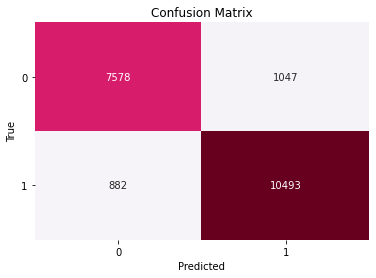

In [42]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes = [0, 1]
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.PuRd, cbar=False)
ax.set(xlabel="Predicted",
       ylabel="True",
       xticklabels=classes,
       yticklabels=classes,
       title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

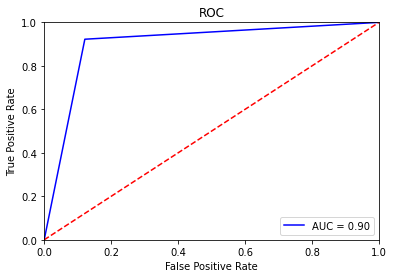

In [43]:
# plot roc curve

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()